In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
from smel_project.models.inception_resnet_v1 import InceptionResnetV1

In [3]:
state_dict_unalt = InceptionResnetV1().state_dict().copy()

## Loading the data

In [82]:
data_trans = transforms.Compose([
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.ToTensor()
])

sets = ['train', 'valid','other']
tr, va, _ = sets

data_set = {}
data_loader = {}
for s in sets:
    data_set[s] = datasets.ImageFolder("./data/faces/"+s,transform=data_trans)
    data_loader[s] = DataLoader(data_set[s], batch_size=4, shuffle=True)

## Defining the fit function

In [6]:
from copy import deepcopy
from time import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model, optim, loss_func, train_dl, valid_dl, epochs=25):
    start = time()
    time_st = lambda x: f"{x//60:0.0f} m {x%60:0.3f} s"
    model = model.to(device)
    losses = []
    
    tr = 'train'
    va = 'valid'
    data = {tr:train_dl, va: valid_dl}
    data_count = {tr: len(train_dl.dataset), va: len(valid_dl.dataset)}
    print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
    best_accu = 0.0
    least_loss = 20
    best_model_state_dict = model.state_dict()
    
    # Add timer
    for epoch in range(epochs): 
        e_start = time()
        
        print(f"\nEPOCH: ({epoch + 1}/{epochs})\t{e_start - start:0.3f} s\n","-"*20) 
        for phase in [tr, va]:
            p_start = time()
            
            is_tr = phase == tr
            is_va = phase == va
            
            if is_tr:
                model.train()
            else:
                model.eval()
             
            """
            Loss and accuracy calculated 
            during a single epoch.
            """
            running_loss = 0.
            running_accu = 0
            
            for batch in data[phase]:
                X, y = batch
                X = X.to(device)
                y = y.to(device)
                
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):  
                    y_val = model(X)
                    y_cls = torch.argmax(y_val, dim=1)
                
                    loss = loss_func(y_val, y)
                
                    if is_tr:
                        loss.backward()
                        optim.step()
                
                """
                Running Loss:
                    Loss calculated over the entire dataset,
                    for one epoch. Loss for an epoch will be 
                    running loss divided by the total number
                    of samples (not batches).
                Running Accuracy:
                    Number of samples the model got right.
                    
                """
                samp_loss = loss.item() * len(y)
                if is_tr:
                    losses.append(samp_loss)
                running_loss += samp_loss
                running_accu += torch.sum(y_cls == y).item()
            
            p_time = time() - p_start
            epoch_loss = running_loss / data_count[phase]
            epoch_accu = running_accu / data_count[phase]
            print(f"{phase}: loss {epoch_loss:0.3f}, accu {epoch_accu:0.3f}, time {time_st(p_time)}")
            
            if is_va and (epoch_accu > best_accu) or (epoch_accu == best_accu and least_loss > epoch_loss):
                best_accu = epoch_accu
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
            elif is_va and least_loss > epoch_loss:
                least_loss = epoch_loss                           
     
    tot_time = time() - start
    print(f"\nTime taken: {time_st(tot_time)}, Best accuracy: {best_accu:0.3f}") 
    return model.load_state_dict(best_model_state_dict), losses

In [38]:
def plot_losses(losses):
    plt.figure(figsize=(20,10))
    plt.plot(range(len(losses)),losses)
    plt.title("Iteration vs Loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

# 1. Altering the model features

In [11]:
inception_resnet_v1 = InceptionResnetV1()
in_features = inception_resnet_v1.last_linear.out_features
out_features = len(data_set[tr].classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for param in inception_resnet_v1.parameters():
    param.requires_grad = False
    
model = nn.Sequential(
    inception_resnet_v1,
    nn.Linear(in_features, out_features),
    nn.LogSoftmax(dim=1)
)

optim = torch.optim.Adam(params=model[1].parameters())
loss_func = nn.NLLLoss()

## Train the model
(Just the last linear layer, everything else is locked)

In [12]:
_, losses_1 = fit(model, optim, loss_func, data_loader[tr], data_loader[va])

train samples: 32, valid samples: 12

EPOCH: (1/25)	0.008 s
 --------------------
train: loss 1.083, accu 0.562, time 0 m 2.428 s
valid: loss 1.062, accu 0.583, time 0 m 0.645 s

EPOCH: (2/25)	3.137 s
 --------------------
train: loss 1.037, accu 0.781, time 0 m 2.304 s
valid: loss 1.019, accu 0.833, time 0 m 0.623 s

EPOCH: (3/25)	6.125 s
 --------------------
train: loss 0.989, accu 0.844, time 0 m 2.306 s
valid: loss 0.995, accu 0.750, time 0 m 0.631 s

EPOCH: (4/25)	9.062 s
 --------------------
train: loss 0.944, accu 0.906, time 0 m 2.303 s
valid: loss 0.967, accu 0.917, time 0 m 0.646 s

EPOCH: (5/25)	12.075 s
 --------------------
train: loss 0.896, accu 0.969, time 0 m 2.468 s
valid: loss 0.919, accu 1.000, time 0 m 0.648 s

EPOCH: (6/25)	15.253 s
 --------------------
train: loss 0.882, accu 0.906, time 0 m 2.479 s
valid: loss 0.882, accu 1.000, time 0 m 0.648 s

EPOCH: (7/25)	18.441 s
 --------------------
train: loss 0.853, accu 0.875, time 0 m 2.547 s
valid: loss 0.845, ac

In [13]:
state_dict_512_to_10_linear = model.state_dict().copy()

## Plotting the losses

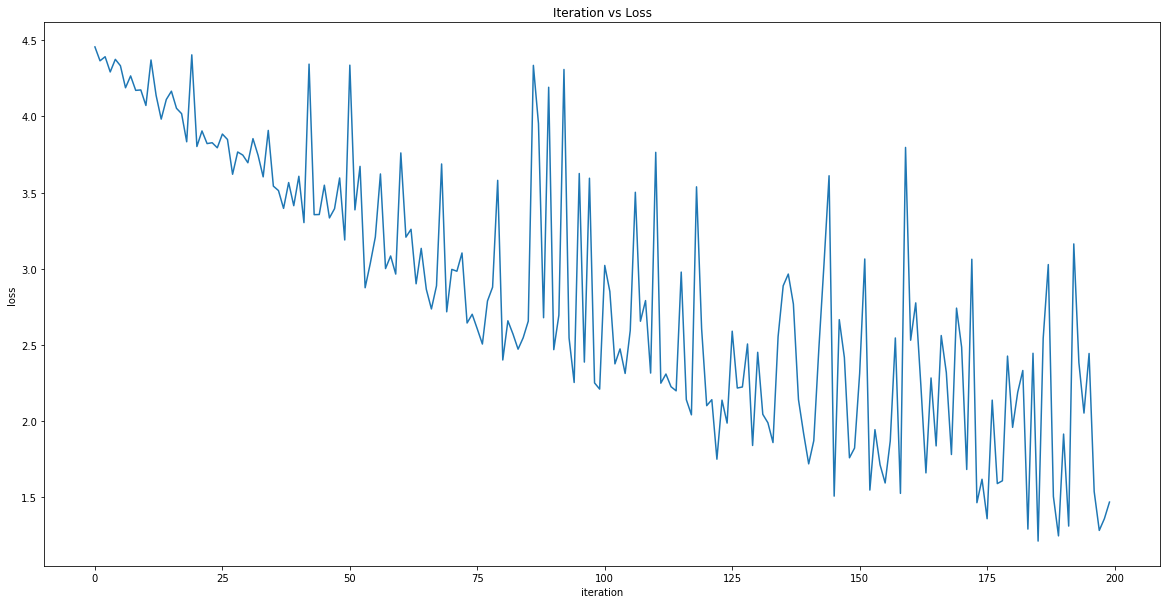

In [14]:
plot_losses(losses_1)

___

# 2. Alter the model some more
Unfreeze the second last linear layer then train.

In [15]:
inception_resnet_v1 = InceptionResnetV1()
in_features = inception_resnet_v1.last_linear.out_features
out_features = len(data_set[tr].classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for param in model.parameters():
    param.requires_grad = False

    
model = nn.Sequential(
    inception_resnet_v1,
    nn.Linear(in_features, out_features),
    nn.LogSoftmax(dim=1)
)


for param in model[0].last_linear.parameters():
    param.requires_grad = True
    
params = list(model[0].last_linear.parameters()) + list(model[1].parameters())
optim = torch.optim.Adam(params=params)
loss_func = nn.NLLLoss()

## Training the model
Last two linear layers

In [16]:
_, losses_2 = fit(model, optim, loss_func, data_loader[tr], data_loader[va])

train samples: 32, valid samples: 12

EPOCH: (1/25)	0.009 s
 --------------------
train: loss 1.028, accu 0.594, time 0 m 7.768 s
valid: loss 0.883, accu 0.917, time 0 m 0.734 s

EPOCH: (2/25)	8.602 s
 --------------------
train: loss 0.825, accu 0.938, time 0 m 8.076 s
valid: loss 0.781, accu 1.000, time 0 m 0.624 s

EPOCH: (3/25)	17.366 s
 --------------------
train: loss 0.759, accu 0.969, time 0 m 7.345 s
valid: loss 0.684, accu 0.917, time 0 m 0.618 s

EPOCH: (4/25)	25.330 s
 --------------------
train: loss 0.720, accu 0.844, time 0 m 7.352 s
valid: loss 0.621, accu 1.000, time 0 m 0.621 s

EPOCH: (5/25)	33.365 s
 --------------------
train: loss 0.592, accu 0.906, time 0 m 7.332 s
valid: loss 0.576, accu 0.917, time 0 m 0.622 s

EPOCH: (6/25)	41.321 s
 --------------------
train: loss 0.608, accu 0.875, time 0 m 7.340 s
valid: loss 0.502, accu 1.000, time 0 m 0.625 s

EPOCH: (7/25)	49.354 s
 --------------------
train: loss 0.484, accu 0.938, time 0 m 7.402 s
valid: loss 0.487, 

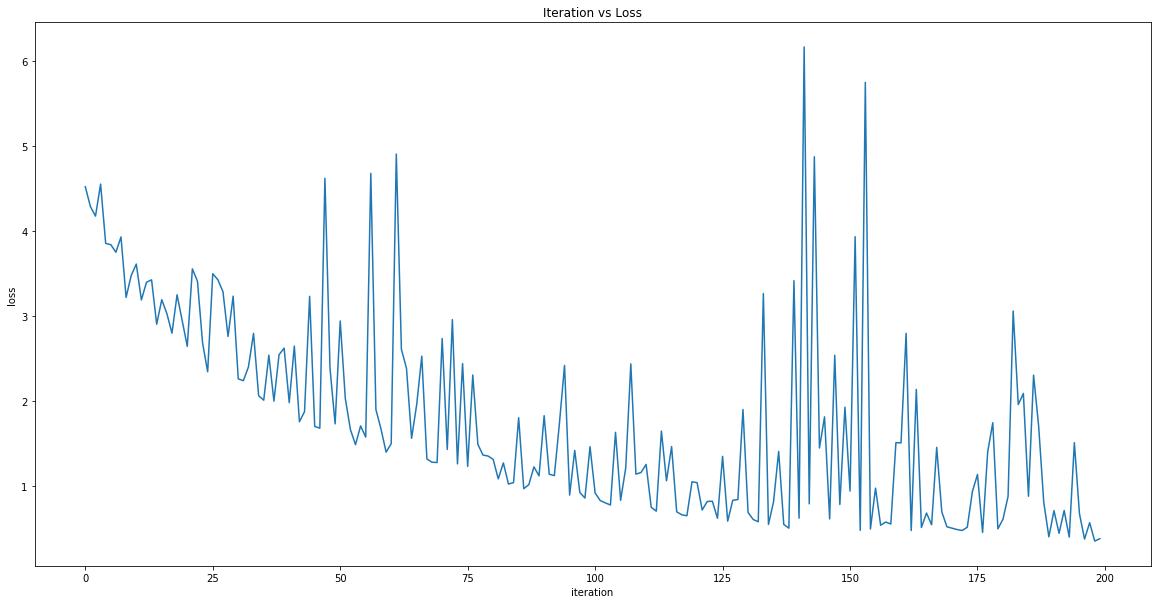

In [17]:
plot_losses(losses_2)

In [18]:
state_dict_2nd_last = model.state_dict().copy()

In [23]:
# Shows that the second last layer has been altered in state dict of the specific model.
(state_dict_unalt['last_linear.weight'] - state_dict_2nd_last['0.last_linear.weight']).sum()

tensor(84.0050)

In [20]:
# Shows that the second last layer hasn't been altered
(state_dict_unalt['last_linear.weight'] - state_dict_512_to_10_linear['0.last_linear.weight']).sum()

tensor(0.)

# 3. Calculating the distance

Function that gets all the vector representation of samples in a dataset along with labels

In [46]:
model_512 = model[0]

def get_repr(data_set, model=model_512):
    vec_repr = []
    vec_labl = []

    model.eval()
    with torch.no_grad():
        for sample in data_set:
            X, y = sample
            vec_repr.append(model(X.reshape(-1,3,160,160)))
            vec_labl.append(y)

    vec_repr = torch.cat(vec_repr)
    return vec_repr, vec_labl

Function to calculate distance between two sets of vectors.

In [47]:
dist_calc = nn.PairwiseDistance(eps=0)

def get_cross_dist(vec_repr_1, vec_repr_2, dist_calc=dist_calc):
    vec_cross_dist = []
    for vec in vec_repr_1:
        vec_cross_dist.append(dist_calc(vec_repr_2,vec))
    return torch.stack(vec_cross_dist) 

In [57]:
vec_repr, vec_labl = get_repr(data_set[tr])
vec_cross_dist = get_cross_dist(vec_repr, vec_repr)

## Displaying the distances for similar and dissimilar classes
The max distance here will be sort of the upper limit for identification ie if the distance is above this max then identification will take place.

In [62]:
# Distance Matrix for every second datapoint (cause all won't fit)

labl = vec_labl[::2]
print("\t",end="")
print('    '.join(map(str,labl)))
for i,vec in enumerate(vec_cross_dist[::2,::2]):
    print(labl[i],end='\t')
    for dist in vec:
        print(f"{dist:0.1f}  ",end="")
    print('\n')

	0    0    0    0    0    0    0    1    1    1    2    2    2    2    2    2
0	0.0  0.2  1.1  0.3  0.4  0.3  0.2  1.6  1.6  1.6  1.9  1.8  1.9  1.9  1.8  1.9  

0	0.2  0.0  1.1  0.3  0.4  0.2  0.3  1.6  1.6  1.6  1.9  1.8  1.9  1.9  1.8  1.9  

0	1.1  1.1  0.0  0.9  1.0  1.1  1.1  1.0  1.2  1.3  1.8  1.8  1.8  1.8  1.8  1.8  

0	0.3  0.3  0.9  0.0  0.4  0.3  0.3  1.5  1.5  1.6  1.9  1.9  1.9  1.9  1.9  1.9  

0	0.4  0.4  1.0  0.4  0.0  0.4  0.4  1.6  1.6  1.6  1.9  1.8  1.9  1.9  1.8  1.9  

0	0.3  0.2  1.1  0.3  0.4  0.0  0.3  1.5  1.6  1.6  1.9  1.8  1.9  1.9  1.8  1.9  

0	0.2  0.3  1.1  0.3  0.4  0.3  0.0  1.6  1.6  1.6  1.9  1.8  1.9  1.9  1.8  1.9  

1	1.6  1.6  1.0  1.5  1.6  1.5  1.6  0.0  0.5  0.6  1.6  1.7  1.6  1.6  1.7  1.6  

1	1.6  1.6  1.2  1.5  1.6  1.6  1.6  0.5  0.0  0.3  1.6  1.7  1.6  1.6  1.7  1.6  

1	1.6  1.6  1.3  1.6  1.6  1.6  1.6  0.6  0.3  0.0  1.5  1.7  1.5  1.6  1.7  1.5  

2	1.9  1.9  1.8  1.9  1.9  1.9  1.9  1.6  1.6  1.5  0.0  0.5  0.5  0.4  0.5  0.4  

In [104]:
def show_min_max(vec_cross_dist, vec_labl_1, vec_labl_2, show_sim=True, show_per_class=False, show_scores=False):
    if show_sim:
        print("showing similar")
    else:
        print("showing dissimilar")
    max_dist = []
    min_dist = []
    log_dist = []
    for i,vec in enumerate(vec_cross_dist):
        if show_per_class:
            print(f"class {vec_labl_1[i]}:",end="\t")
        dists = []
        for j,dist in enumerate(vec):
            if show_scores and show_per_class:
                print(f"{dist:0.1f} ",end=" ")
            if vec_labl_1[i] == vec_labl_2[j] and i != j and show_sim:
                log_dist.append(dist)
                dists.append(dist)
            elif not show_sim and vec_labl_1[i] != vec_labl_2[j]:
                log_dist.append(dist)
                dists.append(dist)

        if len(dists) > 0:
            mx = max(dists)
            mn = min(dists)
            max_dist.append(mx)
            min_dist.append(mn)
            if show_per_class:
                d = ""
                if show_scores:
                    d = "\n\t\t"
                print(f"{d}max: {mx:0.2f}",end="\t") 
                print(f"min: {mn:0.2f}{d}") 

    print('---')
    print(f"alltime max(max) = {max(max_dist)}")
    print(f"alltime min(max) = {min(max_dist)}")
    print(f"mean of max      = {torch.tensor(max_dist).mean()}")
    print()
    print(f"alltime min(min) = {min(min_dist)}")
    print(f"alltime max(min) = {max(min_dist)}")
    print(f"mean of min      = {torch.tensor(min_dist).mean()}")
    print()
    print(f"overall mean     = {torch.tensor(log_dist).mean()}")
    print()

In [100]:
def show_dist_model_stats(model,data_set,show_both=True, show_per_class=False, show_scores=False):
    vec_repr = get_repr(data_set,model)
    dist_matr = calc_all_dist(vec_repr[0],vec_repr[0])
    if show_both:
        show_min_max(dist_matr,vec_repr[1],vec_repr[1],show_sim=True,show_per_class=show_per_class,show_scores=show_scores)
    show_min_max(dist_matr,vec_repr[1],vec_repr[1],show_sim=False,show_per_class=show_per_class,show_scores=show_scores)

In [101]:
# Showing similar distances
show_min_max(vec_cross_dist, vec_labl, vec_labl)

---
alltime max(max) = 1.1240878105163574
alltime min(max) = 0.4531915485858917
mean of max      = 0.7669028043746948

alltime min(min) = 0.17966674268245697
alltime max(min) = 0.8411116600036621
mean of min      = 0.3005406856536865

overall mean     = 0.46522021293640137


In [102]:
# Showing dissimilar distances
show_min_max(vec_cross_dist, vec_labl, vec_labl)

---
alltime max(max) = 1.9782629013061523
alltime min(max) = 1.7013417482376099
mean of max      = 1.9064199924468994

alltime min(min) = 1.0309697389602661
alltime max(min) = 1.634668231010437
mean of min      = 1.3709394931793213

overall mean     = 1.7058550119400024


## Checking the distance with other data

### Validation vs Validation distances

In [103]:
vec_repr_va, vec_labl_va = get_repr(data_set[va])
vec_cross_dist_va = get_cross_dist(vec_repr_va, vec_repr_va)

## Issue - Overlapping of distances
- Below the alltime min(min) for dissimilar classes is less than two all time scores for similar classes.
- So the network needs further training with respect to such cases.
- Perhas train to increase the distances between dissimilar classes.

In [106]:
print("Validation vs validataion\n---")
print("Distances for similar classes: ")
show_min_max(vec_cross_dist_va, vec_labl_va,vec_labl_va,show_sim=True, show_per_class=False)
print("\nDistances for dissimilar classes: ")
show_min_max(vec_cross_dist_va, vec_labl_va,vec_labl_va,show_sim=False, show_per_class=False)

Validation vs validataion
---
Distances for similar classes: 
---
alltime max(max) = 1.3523019552230835
alltime min(max) = 0.6531884670257568
mean of max      = 0.9767659306526184

alltime min(min) = 0.2811989188194275
alltime max(min) = 0.7508862614631653
mean of min      = 0.48940086364746094

overall mean     = 0.7223182916641235

Distances for dissimilar classes: 
---
alltime max(max) = 1.9582387208938599
alltime min(max) = 1.7203199863433838
mean of max      = 1.889237880706787

alltime min(min) = 0.5294368863105774
alltime max(min) = 1.6574366092681885
mean of min      = 0.9010656476020813

overall mean     = 1.4770927429199219


### Validation vs Training distances

In [96]:
vec_cross_dist_vta = get_cross_dist(vec_repr_va, vec_repr)
vec_cross_dist_vta.shape

torch.Size([12, 32])

In [107]:
print("Validation vs training\n---")
print("Distances for similar classes: ")
show_min_max(vec_cross_dist_vta, vec_labl_va,vec_labl,show_sim=True, show_per_class=False)
print("\nDistances for dissimilar classes: ")
show_min_max(vec_cross_dist_vta, vec_labl_va,vec_labl,show_sim=False, show_per_class=False)

Validation vs training
---
Distances for similar classes: 
---
alltime max(max) = 1.6050047874450684
alltime min(max) = 0.4515761733055115
mean of max      = 0.8318262100219727

alltime min(min) = 0.19609951972961426
alltime max(min) = 1.032283902168274
mean of min      = 0.4413498342037201

overall mean     = 0.6371853351593018

Distances for dissimilar classes: 
---
alltime max(max) = 1.97780442237854
alltime min(max) = 1.7109287977218628
mean of max      = 1.882949948310852

alltime min(min) = 0.3398098647594452
alltime max(min) = 1.5440914630889893
mean of min      = 1.1367093324661255

overall mean     = 1.606135368347168


## Checking distance between training data vectors and data not seen by model
Faces of different people

In [98]:
vec_repr_ot, vec_labl_ot = get_repr(data_set['other'])
vec_cross_dist_to = get_cross_dist(vec_repr, vec_repr_ot)
vec_cross_dist_vo = get_cross_dist(vec_repr_va, vec_repr_ot)
vec_cross_dist_to.shape

torch.Size([32, 22])

In [108]:
print("\nDistances training vs other: ")
show_min_max(vec_cross_dist_to, vec_labl,vec_labl_ot,show_sim=False, show_per_class=False)

print("\nDistances validation vs other: ")
show_min_max(vec_cross_dist_vo, vec_labl_va,vec_labl_ot,show_sim=False, show_per_class=False)


Distances training vs other: 
---
alltime max(max) = 1.9061312675476074
alltime min(max) = 1.5257556438446045
mean of max      = 1.792826533317566

alltime min(min) = 0.37941762804985046
alltime max(min) = 1.0008596181869507
mean of min      = 0.6969209313392639

overall mean     = 1.2841312885284424

Distances validation vs other: 
---
alltime max(max) = 1.8979709148406982
alltime min(max) = 1.4898078441619873
mean of max      = 1.708462119102478

alltime min(min) = 0.30497777462005615
alltime max(min) = 1.2959202527999878
mean of min      = 0.6714227199554443

overall mean     = 1.1689237356185913


## Defining a custom loss function
- Loss functon will work only with a batch.
- Will take the n-dim vector representation of images and the labels.
- Then calculate the distance between each other.
- If the labels match the distance should be less.
- If the labels don't match the distance should be more.

In [5]:
dist_calc = nn.PairwiseDistance(eps=1e-8)

def calc_all_dist(x1, x2, dist_func=dist_calc):
    """
    Function that calculates the distances between
    all the vectors in x1 and x2 which are of the
    shape (m1,n) and (m2,n).
    
    n: dimensions in vector
    m1, m2: co-ordinates in x1 and x2 
    
    returns: (m2,m1) shape distance matrix
    """
    dists = []
    for vec in x1:
        dists.append(dist_func(x2,vec))
    return torch.stack(dists)   

In [76]:
def dist_loss(y_vectors:"vectors from the model", y:"labels", dist_calculator=calc_all_dist, sim_thresh=0.2, dis_offset=0.3, eps=1.2):
    """
    dis_calculator: function to calculate distance between all y_vectors
    sim_thresh: distance below which loss doesn't increase if same class
    dis_offset: 1 + dis_offset, below which loss increases is !same class
    eps: factor to raise the dissimilar term by
    
    Loss function to be used if the output of the model is 
    an image embedding and the class of the image is known.
    
    Calculates the distance between all the y_vectors.
    If the classes match the distance increases the loss 
    If the classes don't match the distance decreases loss
    """
    l = y_vectors.size(0)
    
    # Distance between all the y_vectors shape:(l,l)
    dist_matrix = dist_calculator(y_vectors, y_vectors)
    
    # Creating a shape:(l,l) mask using labels
    y_cross = y.repeat(l).reshape(l,l)
    y_mask = torch.eq(y_cross, y_cross.T)
    
    # mean tensor of dissimilar classes distances
    dis_mean = dist_matrix[~y_mask].mean()
    
    # Negating the diagonal cause that dist will be (almost) 0
    temp_tensor = torch.arange(l)
    y_mask[temp_tensor,temp_tensor] = False
    
    # mean tensor of similar classes distances
    sim_mean = dist_matrix[y_mask].mean()
     
    
    nume = sim_mean if sim_mean > sim_thresh else 0.
    deno = dis_mean - dis_offset if dis_mean < (1 + dis_offset) else 1.
    
    # Calculating the loss
    loss = (nume + (1./deno - 1.)**eps)
    return loss if loss > 0 else (sim_mean/dis_mean)

## Redefine the fit function
This is so that the new loss function can be used.

In [33]:
from copy import deepcopy
from time import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def dist_fit(model, optim, loss_func, train_dl, valid_dl=None, epochs=25):
    start = time()
    time_st = lambda x: f"{x//60:0.0f} m {x%60:0.3f} s"
    model = model.to(device)
    losses = []
    valid_is_none = valid_dl is None
    
    # Define datasets dict
    tr = 'train'
    va = 'valid'
    sets = [tr,va]
    if valid_is_none:
        sets = [tr]
    data = {tr:train_dl, va: valid_dl}
    
    # Define datacount dict and printing number of samples.
    data_count = {}
    if not valid_is_none:
        data_count = {tr: len(train_dl.dataset), va: len(valid_dl.dataset)}
        print(f"train samples: {data_count[tr]}, valid samples: {data_count[va]}")
    else:
        data_count = {tr: len(train_dl.dataset)}
        print(f"samples: {data_count[tr]}")
        
    least_loss = torch.tensor(float('inf'))
    best_model_state_dict = deepcopy(model.state_dict())
    
    # Add timer
    for epoch in range(epochs): 
        e_start = time()
        
        print(f"\nEPOCH: ({epoch + 1}/{epochs})\t{e_start - start:0.3f} s\n","-"*20) 
        for phase in sets:
            p_start = time()
            
            is_tr = phase == tr
            if is_tr:
                model.train()
            else:
                model.eval()
             
            running_loss = 0.
            
            for batch in data[phase]:
                X, y = batch
                X = X.to(device)
                y = y.to(device)
                
                optim.zero_grad()
                
                with torch.set_grad_enabled(is_tr):  
                    y_vectors = model(X)
                
                    loss = loss_func(y_vectors, y)
                
                    if is_tr:
                        loss.backward()
                        optim.step()
                
                samp_loss = loss * len(y)
                if is_tr:
                    losses.append(samp_loss)
                running_loss += samp_loss
            
            p_time = time() - p_start
            epoch_loss = running_loss / data_count[phase]
            print(f"{phase}: loss {epoch_loss:0.3f}, time {time_st(p_time)}")
            
            if (not is_tr) and (least_loss > epoch_loss):
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
            elif valid_is_none and (least_loss > epoch_loss):
                least_loss = epoch_loss
                best_model_state_dict = deepcopy(model.state_dict())
                
     
    tot_time = time() - start
    print(f"\nTime taken: {time_st(tot_time)}") 
    return model.load_state_dict(best_model_state_dict), losses

## Retrain network using new parameters

In [77]:
model_ir_v1 = InceptionResnetV1()

# Freeze all the layers
for param in model_ir_v1.parameters():
    param.requires_grad = False
    
# Unfreeze the last_linear layer
for param in model_ir_v1.last_linear.parameters():
    param.requires_grad = True
    
optim = torch.optim.Adam(params=model_ir_v1.last_linear.parameters())

In [78]:
_, losses_3 = dist_fit(model_ir_v1, optim, dist_loss, data_loader[tr], data_loader[va])

train samples: 32, valid samples: 12

EPOCH: (1/25)	0.076 s
 --------------------
train: loss 1.501, time 0 m 2.679 s
valid: loss 0.950, time 0 m 0.767 s

EPOCH: (2/25)	3.614 s
 --------------------
train: loss 1.384, time 0 m 2.728 s
valid: loss 0.948, time 0 m 0.667 s

EPOCH: (3/25)	7.073 s
 --------------------
train: loss 1.093, time 0 m 2.804 s
valid: loss 0.742, time 0 m 0.757 s

EPOCH: (4/25)	10.697 s
 --------------------
train: loss 1.115, time 0 m 2.666 s
valid: loss 0.828, time 0 m 0.678 s

EPOCH: (5/25)	14.042 s
 --------------------
train: loss 0.944, time 0 m 2.886 s
valid: loss 0.978, time 0 m 0.674 s

EPOCH: (6/25)	17.604 s
 --------------------
train: loss 0.994, time 0 m 2.570 s
valid: loss 0.713, time 0 m 0.665 s

EPOCH: (7/25)	20.902 s
 --------------------
train: loss 0.992, time 0 m 2.561 s
valid: loss 0.785, time 0 m 0.671 s

EPOCH: (8/25)	24.135 s
 --------------------
train: loss 0.565, time 0 m 2.563 s
valid: loss 0.431, time 0 m 0.664 s

EPOCH: (9/25)	27.424 

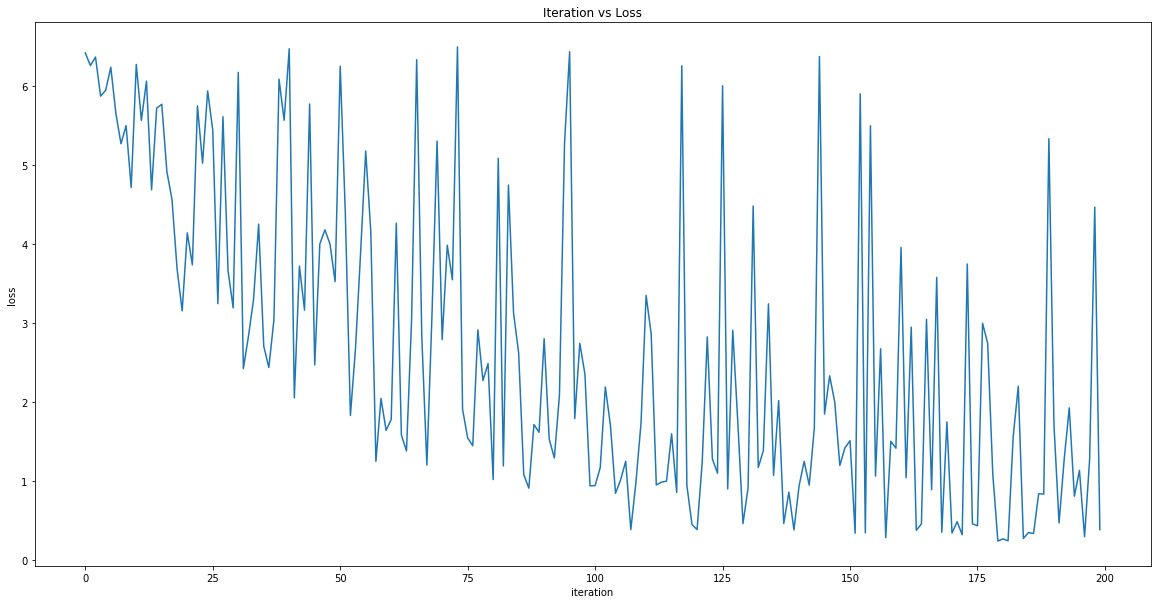

In [79]:
plot_losses(losses_3)

In [80]:
show_dist_model_stats(model_ir_v1, data_set[tr])

showing similar
---
alltime max(max) = 1.3022382259368896
alltime min(max) = 0.15382297337055206
mean of max      = 0.3886925280094147

alltime min(min) = 0.06774977594614029
alltime max(min) = 0.8445866703987122
mean of min      = 0.1396220326423645

overall mean     = 0.1788577437400818

showing dissimilar
---
alltime max(max) = 1.9959354400634766
alltime min(max) = 1.6684684753417969
mean of max      = 1.9674022197723389

alltime min(min) = 0.48322179913520813
alltime max(min) = 1.6684685945510864
mean of min      = 0.986950695514679

overall mean     = 1.6405372619628906



In [74]:
show_dist_model_stats(model_ir_v1, data_set[tr])

showing similar
---
alltime max(max) = 0.5682202577590942
alltime min(max) = 0.07791468501091003
mean of max      = 0.20432817935943604

alltime min(min) = 0.027023663744330406
alltime max(min) = 0.2900729179382324
mean of min      = 0.07938340306282043

overall mean     = 0.10431541502475739

showing dissimilar
---
alltime max(max) = 1.9984259605407715
alltime min(max) = 1.8757399320602417
mean of max      = 1.9829970598220825

alltime min(min) = 0.24341224133968353
alltime max(min) = 1.8757402896881104
mean of min      = 0.9450050592422485

overall mean     = 1.5935959815979004



In [98]:
show_dist_model_stats(model_ir_v1, data_set[va], show_per_class=True, show_scores=True)

showing similar
class 0:	0.0  0.3  0.3  0.3  1.1  0.9  0.3  0.4  2.0  2.0  2.0  2.0  
		max: 0.30	min: 0.30
		
class 0:	0.3  0.0  0.2  0.2  1.2  1.0  0.4  0.5  2.0  2.0  2.0  2.0  
		max: 0.30	min: 0.17
		
class 0:	0.3  0.2  0.0  0.2  1.3  1.0  0.4  0.5  2.0  2.0  2.0  2.0  
		max: 0.30	min: 0.15
		
class 0:	0.3  0.2  0.2  0.0  1.3  1.0  0.4  0.5  2.0  2.0  2.0  2.0  
		max: 0.30	min: 0.15
		
class 1:	1.1  1.2  1.3  1.3  0.0  0.4  1.0  0.9  1.6  1.6  1.6  1.7  
		max: 0.99	min: 0.43
		
class 1:	0.9  1.0  1.0  1.0  0.4  0.0  0.8  0.6  1.7  1.8  1.8  1.8  
		max: 0.75	min: 0.43
		
class 1:	0.3  0.4  0.4  0.4  1.0  0.8  0.0  0.2  2.0  2.0  2.0  2.0  
		max: 0.99	min: 0.23
		
class 1:	0.4  0.5  0.5  0.5  0.9  0.6  0.2  0.0  2.0  2.0  2.0  2.0  
		max: 0.89	min: 0.23
		
class 2:	2.0  2.0  2.0  2.0  1.6  1.7  2.0  2.0  0.0  0.1  0.1  0.4  
		max: 0.36	min: 0.12
		
class 2:	2.0  2.0  2.0  2.0  1.6  1.8  2.0  2.0  0.1  0.0  0.1  0.3  
		max: 0.31	min: 0.10
		
class 2:	2.0  2.0  2.0  2.0  1.6  

In [105]:
show_dist_model_stats(model_ir_v1, data_set['other'])

showing similar
---
alltime max(max) = 1.8132100105285645
alltime min(max) = 0.3508339822292328
mean of max      = 0.8387879133224487

alltime min(min) = 0.2265329360961914
alltime max(min) = 1.6102173328399658
mean of min      = 0.47556695342063904

overall mean     = 0.6031926870346069

showing dissimilar
---
alltime max(max) = 1.9432710409164429
alltime min(max) = 1.651796817779541
mean of max      = 1.847774863243103

alltime min(min) = 0.2886527180671692
alltime max(min) = 0.6807420253753662
mean of min      = 0.5132593512535095

overall mean     = 1.295510172843933



## General pipeline
- Person stands in front of videocam running at `x` fps for a few seconds and moves head side to side
- This gives a good representation of face
- 512 vector representation is calculated 
- When a person walks through distance is calculated with this representation and the k nearest is used to classify

## Need to 
- Create a script to take persons crops from input video.
- Create a script to automatically train the network on the set of saved images
  should also decide test and validation split and store the representation 
  vectors from the second last linear layer, along with the labels.
- Create a script to calculate threshold from stored vectors of images.
- Check distance between training and validation data this will be more useful for threshold.
- Check distance between some test and training set.
- Complete the pipeline.

## Conclusion
- The distance function seems to work kind fine I guess
- Need to try these with more data, 32 samples if far too few.
    - Unfreezing the last linear layer to get vector representations
    - Using a normal loss function
    - Using the custom loss function
- Currently need to do the other things that need to be done and spend less time on the learning part